# Molecular dynamics simulations of a water slab

In this example, we will try to perform molecular dynamics of a water slab using the simple interatomic TIP3P potential
([W. L. Jorgensen et. al.](https://doi.org/10.1063/1.445869)) and [LAMMPS](http://lammps.sandia.gov/). 

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
from pyiron_atomistics.structure.atoms import Atoms
from pyiron_atomistics.structure.periodic_table import PeriodicTable
from pyiron.project import Project
import matplotlib
import ase.units as units
from numpy import in1d

In [2]:
pr = Project("tip3p_water")

## Creating the initial structure

We will setup a cubic simulation box which will enclose 27 water molecules such that the density is 1 g/cc. This is done by determining the required size of the simulation cell and repeating 27 unit cells of each with one water molecule to match the target density

In [3]:
density = 1.0e6  # g/m3
n_mols = 27

# Determining the supercell size size
mass = 18.015 * n_mols / units.mol  # g
vol_h2o = mass / density * 1e30
a = vol_h2o ** (1./3.)

# Constructing the unitcell
n = int(round(n_mols ** (1. / 3.)))
a_unitcell = a * (1./n)
dx = 0.7
r_O = [0, 0, 0]
r_H1 = [dx, dx, 0]
r_H2 = [-dx, dx, 0]
unit_cell = a_unitcell * np.eye(3)
water = Atoms(elements=['H', 'H', 'O'], 
                      positions=[r_H1, r_H2, r_O], cell=unit_cell)
water.set_repeat([n, n, n])
water.plot3d()

NGLWidget()

In [4]:
water.get_chemical_formula()

'H54O27'

## Dynamics using a small time step

The initial structure in this simulation is obviously a poor starting point for our calculations. However, dynamics using a small time-step will help us generate a structure which resembles that of water/ice (based on the temperature). We will use the NVT ensemble for this calculation

In [5]:
temp = 300
steps = 1e4
time_step = 0.01 # fs

In [6]:
job_name = "water_slow".format(str(int(temp)))
ham = pr.create_job("Lammps", job_name)
ham.structure = water
# Listing available potentials for this structure
ham.list_potentials()

['H2O_tip3p', 'H2O_tip3p_slab']

We will use the `H2O_tip3p` potential. The `H2O_tip3p_slab` should be used if you want to switch the periodic boundary conditions along the z-axis  

In [7]:
ham.potential = 'H2O_tip3p'

In [8]:
ham.calc_md(temperature=temp, n_ionic_steps=steps, dt=time_step)

In [9]:
ham.run()

In [10]:
view = ham.animate_structure()
view

NGLWidget(count=101)

## Faster dynamics

At the end of this simulation, we have obtained a structure that at least resembles a slab of water molecules. Now we can increase the time step to perform dynamics to get a reasonably equilibriated structure 

In [11]:
# Get the final structure
struct = ham.get_structure(iteration_step=-1)

time_step = 1
steps = 1e4
job_name = "water_fast".format(str(int(temp)))
ham_fast = pr.create_job("Lammps", job_name)
ham_fast.structure = struct
ham_fast.potential = 'H2O_tip3p'
n_print = 10 # output every n_print steps
ham_fast.calc_md(temperature=temp, n_ionic_steps=steps, n_print=n_print, dt=time_step)
ham_fast.run()

In [12]:
view = ham_fast.animate_structure()
view

NGLWidget(count=1001)

We can now plot the trajectories

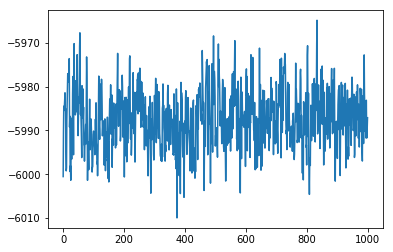

In [13]:
plt.plot(ham_fast["output/generic/energy_pot"])

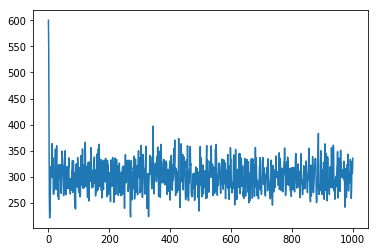

In [14]:
plt.plot(ham_fast["output/generic/temperatures"])

## Computing neighbors and further analysis

We will now use the `get_neighbors()` function to compute structural properties during the course of the simulation. We take advantage of the fact that the TIP3P water model is a rigid water model which means the neighbors need to be indexed only once

In [15]:
final_struct = ham_fast.get_structure(iteration_step=-1)

# Get the indices based on species
O_indices = final_struct.select_index("O")
H_indices = final_struct.select_index("H")

# Getting only the first two neighbors
neighbors = final_struct.get_neighbors(num_neighbors=2)

### Distribution of the O-H bond length

The immediate two neighbors of every O atom has to be H atoms

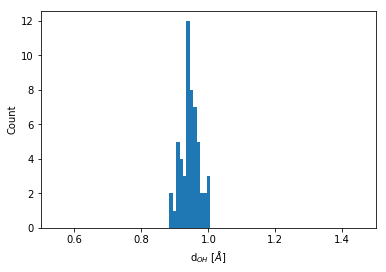

In [16]:
bins = np.linspace(0.5, 1.5, 100)
_ = plt.hist(np.hstack(neighbors.distances[O_indices]), bins=bins)
plt.xlim(0.5, 1.5)
plt.xlabel("d$_{OH}$ [$\AA$]")
plt.ylabel("Count");

### Distribution of the O-O bond lengths

Here we need to compute more neighbors than the nearest 2. We could also do this using a cutoff distance

In [17]:
neighbors = final_struct.get_neighbors(cutoff=8)

In [18]:
neigh_indices = np.hstack(neighbors.indices[O_indices])
neigh_distances = np.hstack(neighbors.distances[O_indices])

We now need only the distances between the O atoms. We can exclude the H atoms using a few simple index manipulation steps

In [19]:
O_neigh_indices  = in1d(neigh_indices, O_indices)
O_neigh_distances = neigh_distances[O_neigh_indices]

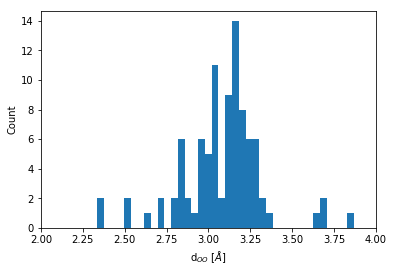

In [20]:
bins = np.linspace(1, 5, 100)
count = plt.hist(O_neigh_distances, bins=bins)
plt.xlim(2, 4)
plt.xlabel("d$_{OO}$ [$\AA$]")
plt.ylabel("Count");